## Import OSM Map into database
### Get the regioni boundries

In [2]:
import os
from dotenv import load_dotenv
import psycopg2
import osmnx as ox
from shapely.geometry import Polygon, MultiPolygon

# Get info from .env file
load_dotenv('.env')
db_name = os.getenv('DB_NAME')
user = os.getenv('USER')
password = os.getenv('PASSWORD')
host = os.getenv('HOST')
if not all([db_name, user, password, host]):
    raise ValueError("Plz set environment variables in .env file")
try:
    conn = psycopg2.connect(dbname=db_name, user=user, password=password, host=host)
    conn.autocommit = True
    cursor = conn.cursor()
    # Delete table if exits
    cursor.execute("DROP TABLE IF EXISTS osm_regioni  CASCADE;")
    conn.commit()

    # Creat table
    create_query = """
    CREATE TABLE osm_regioni (
        id SERIAL PRIMARY KEY,
        nome VARCHAR(255),
        geom GEOMETRY(MultiPolygon, 4326),
        osmid INTEGER,
        lat NUMERIC,
        lon NUMERIC
    );
    """
    cursor.execute(create_query)
    conn.commit()

    # Get OSM data by OSM ID
    query = "SELECT * FROM regioni"
    cursor.execute(query)
    rows = cursor.fetchall()
    osmId_list = [row[2] for row in rows]
    for osm_id in osmId_list:
        try:
            gdf = ox.geocode_to_gdf("R" + str(osm_id), 1, True)
            geometry = gdf.iloc[0].geometry
            name = gdf.name.iloc[0]
            osm_id = gdf.osm_id.iloc[0]
            lat = gdf.lat.iloc[0]
            lon = gdf.lon.iloc[0]                     
            if isinstance(geometry, Polygon):
                geometry = MultiPolygon([geometry])
            wkt_geom = geometry.wkt
            insert_query = """
            INSERT INTO osm_regioni (nome, geom, osmid, lat, lon)
            VALUES (%s, ST_SetSRID(ST_GeomFromText(%s), 4326),%s, %s, %s);
            """
            cursor.execute(insert_query, (name, wkt_geom, int(osm_id), lat, lon))
            conn.commit()
        except Exception as error:
            print(f"Error: {error}")
    cursor.close()
    conn.close()
except Exception as error:
    print(f"Error: {error}")


### Get the province boundries

In [4]:
import psycopg2
import osmnx as ox
from shapely import wkb
from shapely.geometry import Polygon, MultiPolygon

try:
    conn = psycopg2.connect(dbname=db_name, user=user, password=password, host=host)
    conn.autocommit = True
    cursor = conn.cursor()
    # Delete table if exits
    cursor.execute("DROP TABLE IF EXISTS osm_province CASCADE;")
    conn.commit()

    # Creat table
    create_query = """
    CREATE TABLE osm_province (
        id SERIAL PRIMARY KEY,
        nome VARCHAR(255),
        geom GEOMETRY(MultiPolygon, 4326),
        osmid INTEGER,
        lat NUMERIC,
        lon NUMERIC
    );
    """
    cursor.execute(create_query)
    conn.commit()

    # Get OSM data by OSM ID
    query = "SELECT * FROM province"
    cursor.execute(query)
    rows = cursor.fetchall()   
    osmId_list = [row[2] if row[2] is not None else row[1] for row in rows]
    for osm_id in osmId_list:
        if type(osm_id) is str:
            if 'Unità' in osm_id:
                osm_name = "Ente di decentramento regionale di " + osm_id.split()[-1]
            else:
                osm_name = osm_id.split()[-1]
            gdf = ox.geocode_to_gdf(osm_name)
        else:
            try:
                gdf = ox.geocode_to_gdf("R" + str(osm_id), 1, True)
            except:
                cursor.execute("SELECT nome FROM province WHERE osmid = %s", (osm_id,))
                data = cursor.fetchall()
                osm_name = data[0][0]
                gdf = ox.geocode_to_gdf(osm_name,1)
        geometry = gdf.iloc[0].geometry
        name = gdf.name.iloc[0]
        osm_id = gdf.osm_id.iloc[0]
        lat = gdf.lat.iloc[0]
        lon = gdf.lon.iloc[0]
        if not isinstance(geometry, MultiPolygon):
            geometry = MultiPolygon([geometry])
        wkt_geom = geometry.wkt
        insert_query = """
        INSERT INTO osm_province (nome, geom, osmid, lat, lon)
        VALUES (%s, ST_SetSRID(ST_GeomFromText(%s), 4326),%s, %s, %s);
        """
        cursor.execute(insert_query, (name, wkt_geom, int(osm_id),lat, lon))
        conn.commit()
    cursor.close()
    conn.close()
except Exception as error:
    print(f"Error: {error}")


### Interactive map

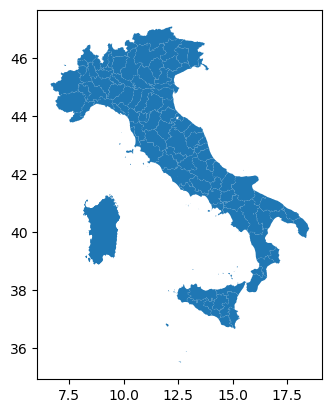

In [5]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

try:
    conn = psycopg2.connect(dbname=db_name, user=user, password=password, host=host)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM osm_province")
    
    rows = cursor.fetchall()

    colnames = [desc[0] for desc in cursor.description]

    cursor.close()
    conn.close()

    data = []
    for row in rows:
        geom = wkb.loads(row[colnames.index('geom')], hex=True)
        attributes = {colnames[i]: row[i] for i in range(len(row)) if colnames[i] != 'geom'}
        attributes['geometry'] = geom
        data.append(attributes)

    gdf = gpd.GeoDataFrame(data, crs='EPSG:4326')
    gdf.plot()


except Exception as error:
    print(f"Error: {error}")

